# Navigation

---

Deep Q-learning algorithm remains relevant and capable of solving many classic RL tasks. This notebook explores the application of DQN to solve the Unity environment "Banana".

### 1. Start the Environment



The enviroment can be run from executable provided as described in the readme.md of this repo. Please provide the path to the file below. 

In [1]:
!pip -q install ./python
!pip -q install bayesian-optimization

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# please update if path to file is inaccurate. (This assumes it was unzipped in the same folder as this notebook)
# env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Defining the Deep-Q-Network:

This notebook uses a simplified MLP with two hidden layers with 64 'relu' units.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Next, we re-use code provided in the [Udacity tutorial](https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py) to define the Agent class that trains and maintaines our deep RL agent. 

In [4]:
from collections import namedtuple
import torch.optim as optim


BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment.
    
    Original code: https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py
    """
    
    def __init__(self, state_size, action_size, seed, buffer_size, tau, update_every):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.buffer_size = buffer_size      # replay buffer size
        self.tau = tau                      # for soft update of target parameters
        self.update_every = update_every    # how often to update the network
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque( maxlen=int( buffer_size)  )  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### Training Loop:
Now let's train the agent until it solves the enviorment (Achieves a score of > 13 average over 100 consequetive episodes).

In [5]:
def dqn(agent, n_episodes=1000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(int(action) )[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]  
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, i_episode-100


Training using parameters found through Bayesian optimization (Optimization code towards the bottom)

Episode 100	Average Score: 9.31
Episode 200	Average Score: 12.06
Episode 292	Average Score: 13.05
Environment solved in 192 episodes!	Average Score: 13.05


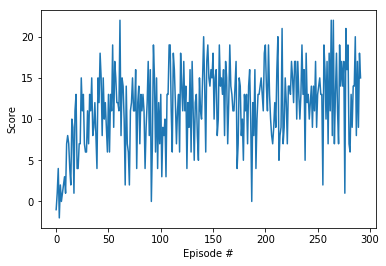

In [6]:
agent = Agent(state_size=37, action_size=4, seed=1, buffer_size =int(3.578e+5), tau = 0.008205, update_every= 4)
scores, solved_in = dqn(agent=agent, eps_decay=0.8058 )

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Parameter optimization using BayesianOptimization package

In [ ]:
from bayes_opt import BayesianOptimization


def dqn_wrapper(buffer_size, tau, eps_decay):
    agent = Agent(state_size=37, action_size=4, seed=0, buffer_size =buffer_size, tau = tau, update_every= 4)
    scores, solved_in = dqn(agent=agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=eps_decay)
        
    return -solved_in


pbounds = {'buffer_size': (int(1e4), int(1e6)), 'tau': (1e-4, 1e-2), 'eps_decay': (0.8, 1.0)}

optimizer = BayesianOptimization(
    f=dqn_wrapper,
    pbounds=pbounds,
    random_state=47
)

optimizer.probe(
    params={'buffer_size': int(1e5), 'tau': 1e-3, 'eps_decay': 0.995},
    lazy=True,
)

optimizer.maximize( 
    init_points=3,
    n_iter=20
)





|   iter    |  target   | buffer... | eps_decay |    tau    |
-------------------------------------------------------------
Episode 100	Average Score: 0.89
Episode 200	Average Score: 4.45
Episode 300	Average Score: 8.09
Episode 400	Average Score: 10.65
Episode 500	Average Score: 12.03
Episode 542	Average Score: 13.02
Environment solved in 442 episodes!	Average Score: 13.02
|  1        | -442.0    |  1e+05    |  0.995    |  0.001    |
Episode 100	Average Score: 1.07
Episode 200	Average Score: 5.47
Episode 300	Average Score: 8.05
Episode 400	Average Score: 9.24
Episode 500	Average Score: 10.86
Episode 600	Average Score: 12.02
Episode 660	Average Score: 13.01
Environment solved in 560 episodes!	Average Score: 13.01
|  2        | -560.0    |  1.224e+0 |  0.9949   |  0.007314 |
Episode 100	Average Score: 7.15
Episode 200	Average Score: 12.25
Episode 255	Average Score: 13.03
Environment solved in 155 episodes!	Average Score: 13.03
|  3        | -155.0    |  3.58e+05 |  0.9415   |  0.008016 |

In [9]:
env.close()